# Classification

- multi-class classification (detects single object in a picture)
- multi-label classification (detects multiple different objects in hte picture)

#### Image segmentation

Selecting all pixels that belong to a segment (object)
- semantic segmentation (all objects form single segment, each pixel associated to one segemnt) 
- instance segmentation (objects of the same type are treated as different object)

---

## Transfer learning

Applying `weights` of one model to another model `instead of initializing weights randomly`. Can be made with different but similar datasets (like cat vs dog and cow vs horse)
- saves time & cost
- improved performance on small datasets

In order to use data of a different size (images) we have to rezise it to the dimentions that pretrained model expects.

`resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)`

where size=(7,7) means multipylng th size of image by 7.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
import zipfile
import urllib.request

#### data

In [3]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "catsdogs.zip"
download_dir = './tmp/'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [4]:
print("Number of cat images:",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images: 12501
Number of dog images: 12501


In [10]:
os.mkdir('/tmp/cats-v-dogs')
os.mkdir('/tmp/cats-v-dogs/training')
os.mkdir('/tmp/cats-v-dogs/testing')
os.mkdir('/tmp/cats-v-dogs/training/cats')
os.mkdir('/tmp/cats-v-dogs/training/dogs')
os.mkdir('/tmp/cats-v-dogs/testing/cats')
os.mkdir('/tmp/cats-v-dogs/testing/dogs')

In [7]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [11]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2, horizontal_flip=True,fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size=100, class_mode='binary', target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,batch_size=100,class_mode='binary',target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


#### model

In [12]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x1ced8492eb0>)

In [13]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),include_top=False,weights=None)
pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


`Create model`

In [16]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

#### training

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['acc'])
history = model.fit(train_generator,validation_data=validation_generator,epochs=2,verbose=1)

C:\Users\pk764\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/2
225/225 [==============================] - ETA: 0s - loss: 0.2389 - acc: 0.9094

C:\Users\pk764\miniconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 808s 4s/step - loss: 0.2389 - acc: 0.9094 - val_loss: 0.0799 - val_acc: 0.9676
Epoch 2/2
225/225 [==============================] - 587s 3s/step - loss: 0.1522 - acc: 0.9371 - val_loss: 0.0846 - val_acc: 0.9696


#### inference

In [34]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

path='/tmp/cats-v-dogs/testing/cats/13.jpg'
#path='/tmp/cats-v-dogs/testing/dogs/11.jpg'
img = load_img(path, target_size=(150, 150))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(classes[0])
if classes[0]>0.5:
    print(" is a dog")
else:
    print(" is a cat")

[4.198254e-09]
 is a cat


---

# Object localization

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

C:\Users\pk764\miniconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### data

In [188]:
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])
  
def get_training_dataset():
      with  strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat() # Mandatory for Keras for now
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
        dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
      return dataset

def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

#### model

In [42]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    return x

In [43]:
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x

In [44]:
def classifier(inputs):
  classification_output = tf.keras.layers.Dense(10, activation='softmax', name = 'classification')(inputs)
  return classification_output

In [45]:
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output

In [46]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)
    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])
    return model

In [47]:
def define_and_compile_model(inputs):
  model = final_model(inputs)
  model.compile(optimizer='adam', 
              loss = {'classification' : 'categorical_crossentropy','bounding_box' : 'mse'},
              metrics = {'classification' : 'accuracy','bounding_box' : 'mse'})
  return model

with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
  model = define_and_compile_model(inputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 73, 73, 16)   160         ['input_2[0][0]']                
                                                                                                  
 average_pooling2d_9 (AveragePo  (None, 36, 36, 16)  0           ['conv2d_94[0][0]']              
 oling2D)                                                                                         
                                                                                                  
 conv2d_95 (Conv2D)             (None, 34, 34, 32)   4640        ['average_pooling2d_9[0][0]

#### training

In [40]:
strategy = tf.distribute.get_strategy()
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [56]:
EPOCHS = 10 # 45
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)
loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
937/937 [==============================] - 125s 132ms/step - loss: 1.0195 - classification_loss: 1.0040 - bounding_box_loss: 0.0155 - classification_accuracy: 0.6455 - bounding_box_mse: 0.0155 - val_loss: 0.3207 - val_classification_loss: 0.3109 - val_bounding_box_loss: 0.0099 - val_classification_accuracy: 0.9053 - val_bounding_box_mse: 0.0099
Epoch 2/10
937/937 [==============================] - 123s 131ms/step - loss: 0.2683 - classification_loss: 0.2618 - bounding_box_loss: 0.0065 - classification_accuracy: 0.9201 - bounding_box_mse: 0.0065 - val_loss: 0.2099 - val_classification_loss: 0.2059 - val_bounding_box_loss: 0.0041 - val_classification_accuracy: 0.9399 - val_bounding_box_mse: 0.0041
Epoch 3/10
937/937 [==============================] - 125s 133ms/step - loss: 0.1968 - classification_loss: 0.1934 - bounding_box_loss: 0.0034 - classification_accuracy: 0.9422 - bounding_box_mse: 0.0034 - val_loss: 0.1291 - val_classification_loss: 0.1267 - val_bounding_box_loss: 0.

#### results

In [195]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color='red',thickness=1,display_str=None,use_normalized_coordinates=True):
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=thickness, fill=color)

def draw_bounding_boxes_on_image(image,boxes,thickness=1,display_str_list=()):
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],boxes[i, 2],)
        
def draw_bounding_boxes_on_image_array(image,boxes,thickness=1,display_str_list=()):
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes)
  return np.array(rgbimg)

In [146]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)
    smoothing_factor = 1e-10
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [166]:
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

In [189]:
(training_digits, training_labels, training_bboxes,validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

In [190]:
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)
predicted_bboxes = predictions[1]
iou = intersection_over_union(predicted_bboxes, validation_bboxes)
iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

Number of predictions where iou > threshold(0.6): 9349
Number of predictions where iou < threshold(0.6): 651


True label: 2
Prediction: 2


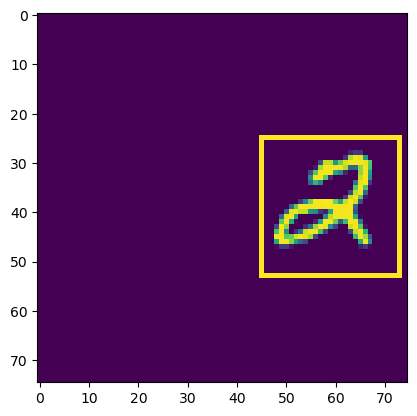

In [218]:
validation_digits[0]
img=validation_digits[0].reshape(75,75)
print(f'True label: {predicted_labels[0]}')
print(f'Prediction: {validation_labels[0]}')

predictions[1][0]
pred=predictions[1][0].reshape(1,4)
box=draw_bounding_boxes_on_image_array(img,pred)
new_box=[]
for i in box:
    k=[]
    for j in i:
        k.append(j[0])
    new_box.append(k)
new_box=np.array(new_box,dtype="float32")
image=new_box/255+img
plt.imshow(image)

---

#### displaying training images and boxes

In [219]:
training_dataset

<PrefetchDataset shapes: ((64, 75, 75, 1), ((64, 10), (64, 4))), types: (tf.float32, (tf.float32, tf.float32))>

In [230]:
for image, label in tfds.as_numpy(training_dataset.take(1)):
  print(type(image), type(label))

<class 'numpy.ndarray'> <class 'tuple'>


In [231]:
import matplotlib.pyplot as plt

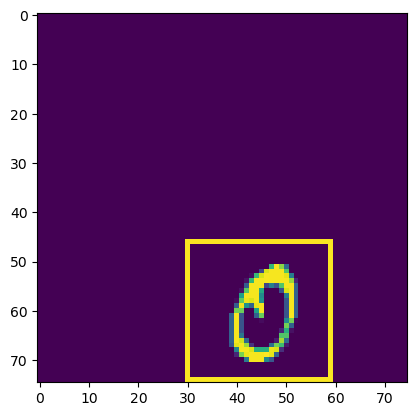

In [232]:
img=image[0].reshape(75,75)
lab=label[1][0]
lab=lab.reshape(1,4)
box=draw_bounding_boxes_on_image_array(img,lab)
new_box=[]
for i in box:
    k=[]
    for j in i:
        k.append(j[0])
    new_box.append(k)
new_box=np.array(new_box,dtype="float32")
image=new_box/255+img
plt.imshow(image)